In [ ]:
import tensorflow as tf
from transformers import TFXLMRobertaModel, XLMRobertaTokenizer
from transformers import AutoImageProcessor, TFViTModel

tokenizer = XLMRobertaTokenizer.from_pretrained("jplu/tf-xlm-roberta-base")
XLM_RoBERTa = TFXLMRobertaModel.from_pretrained("jplu/tf-xlm-roberta-base")

image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
ViT = TFViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
import numpy as np
from PIL import Image

users = 4
posts = 8
traits = ['O','C','E','A','N']

In [ ]:
images = [np.random.randint(0,255,size=(480,640,3),dtype=np.uint8) for i in range(users*posts)]
image_inputs = image_processor(images, return_tensors="tf")

captions = [f'user {user} text {i}' for user in range(users) for i in range(posts)]
text_inputs =  tokenizer(captions, padding='max_length', truncation=True, return_tensors="tf",max_length=196)

In [ ]:
class Model(tf.keras.models.Model):
  def __init__(self,units=768, num_heads=8, dropout_rate=0.2, ff_units=16, users=users, posts=posts):
        super().__init__()

        self.u = users
        self.p = posts
        self.units = units

        self.embedding = tf.keras.layers.Embedding(input_dim=2, output_dim=units) # represent the query
        self.q1 = tf.constant([[0] for i in range(self.u*self.p)], dtype=tf.int32) # first query
        self.q2 = tf.constant([[1] for i in range(self.u)], dtype=tf.int32) # second query

        self.XLM_RoBERTa = XLM_RoBERTa
        self.ViT = ViT

        self.mha = tf.keras.layers.MultiHeadAttention(
            num_heads = num_heads,
            key_dim = self.units,
            value_dim = self.units,
            dropout = dropout_rate
        )

        self.mha_cls  = tf.keras.layers.MultiHeadAttention(
            num_heads = num_heads,
            key_dim = self.units,
            value_dim = self.units,
            dropout = dropout_rate
        )

        self.seq = tf.keras.Sequential([
            tf.keras.layers.Dense(units=2*units, activation='relu'),
            tf.keras.layers.Dense(units=units),
            tf.keras.layers.Dropout(rate=dropout_rate),
        ])

        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()


        # Classification Heads
        self.ff = [tf.keras.Sequential([
            tf.keras.layers.Dropout(dropout_rate),
            tf.keras.layers.Dense(ff_units,activation='relu'),
            tf.keras.layers.Dense(1)
        ],
          name=_)
        for _ in traits
        ]

  def call(self,tokens,images):
        x = self.XLM_RoBERTa(tokens)       # (u*p,seq_len,768)
        text_pooled_output = x.pooler_output  # (u*p,768)

        outputs = self.ViT(**images)   # (u*p,197,768)
        image_pooled_output = outputs.pooler_output  # (u*p,768)

        x = tf.stack([text_pooled_output,image_pooled_output],axis=1)  # (u*p,2,768)


        # Posts Attention
        query = self.embedding(self.q1)
        attn, attention_scores_posts = self.mha(
             query=query, value=x,
             return_attention_scores=True)
        self.last_attn_scores_posts = attention_scores_posts

        x = self.add([query, attn])
        x = self.layernorm(x)
        x = x + self.seq(x)
        x = self.layernorm(x)

        x = x[:,0,:]  # (u*p,768)


        # cls attention
        x = tf.reshape(x,(self.u,self.p,768)) # (u,p,768)
        query = self.embedding(self.q2)
        attn, attention_scores_cls = self.mha_cls(
             query=query, value=x,
             return_attention_scores=True)
        self.last_attn_scores_cls = attention_scores_cls
        x = attn[:,0,:]

        # Regression
        return [h(x) for h in self.ff]

In [ ]:
model = Model()
logits = model(text_inputs,image_inputs)
logits

In [ ]:
model.last_attn_scores_posts.shape

TensorShape([32, 8, 1, 2])

In [ ]:
model.last_attn_scores_cls.shape

TensorShape([4, 8, 1, 8])

$$$$

## Keras APIs levels

**Final Model**

In [ ]:
fixed_seq_len = 256
dropout_rate = 0.2
units = 768
u = 4
p = 8

## Text Inputs
input_ids = tf.keras.layers.Input(shape=(fixed_seq_len,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.layers.Input(shape=(fixed_seq_len,), dtype=tf.int32, name='attention_mask')
inputs = {'input_ids':input_ids,'attention_mask':attention_mask}

text_pooled_output = XLM_RoBERTa(inputs).pooler_output

## ViT Inputs
images_inputs = {'pixel_values':tf.keras.layers.Input(shape=(3,224,224), dtype=tf.float32, name='pixel_values')}
image_pooled_output = ViT(images_inputs).pooler_output

x = tf.keras.layers.Lambda(lambda x: tf.stack(x, axis=1),name='pooled_output')([text_pooled_output, image_pooled_output])

## Query EMbeddings
embedding_layer = tf.keras.layers.Embedding(input_dim=2, output_dim=768)
q1 = tf.keras.layers.Lambda(lambda _: tf.constant([[0] for _ in range(users * posts)], dtype=tf.int32),name='query_1')([])
q2 = tf.keras.layers.Lambda(lambda _: tf.constant([[1] for _ in range(users)], dtype=tf.int32),name='query_2')([])

## MHA layers
mha = tf.keras.layers.MultiHeadAttention(
    num_heads=8,
    key_dim=units,
    value_dim=units,
    dropout=dropout_rate,
    name='posts_attn'
)
mha_cls = tf.keras.layers.MultiHeadAttention(
    num_heads=8,
    key_dim=units,
    value_dim=units,
    dropout=dropout_rate,
    name='cls_attn'
)

## Posts Attn
query = embedding_layer(q1)
attn = mha(
    query=query,
    value=x,
)
x = tf.keras.layers.Add(name='add')([query, attn])
x = tf.keras.layers.LayerNormalization()(x)

seq = tf.keras.Sequential([
    tf.keras.layers.Dense(units=2*units, activation='relu'),
    tf.keras.layers.Dense(units=units),
    tf.keras.layers.Dropout(rate=dropout_rate),
],
    name='seq'
                          )
seq_out = seq(x)
x = tf.keras.layers.Lambda(lambda x: x[0] + x[1], name='add_layer')([x, seq_out])
x = tf.keras.layers.Lambda(lambda x: x[:, 0, :], name='slice_layer_1')(x)

## Posts Attn
x = tf.keras.layers.Lambda(lambda x: tf.reshape(x, (u, p, units)), name='reshape_layer')(x)
query = embedding_layer(q2)
attn = mha_cls(
    query=query,
    value=x,
)
x = tf.keras.layers.Lambda(lambda x: x[:, 0, :], name='slice_layer_2')(attn)

## Regression Heads
x = tf.keras.layers.Dropout(dropout_rate,name='regression_dropout')(x)

O = tf.keras.layers.Dense(1,name='O')(x)
C = tf.keras.layers.Dense(1,name='C')(x)
E = tf.keras.layers.Dense(1,name='E')(x)
A = tf.keras.layers.Dense(1,name='A')(x)
N = tf.keras.layers.Dense(1,name='N')(x)

model = tf.keras.models.Model([inputs,images_inputs], [O, C, E, A, N])

model.compile(
              # since we have two output layer, we can define two loss function
              loss = {
                  k:tf.keras.losses.MeanSquaredError() for k in traits
              },
              optimizer = 'adam',
              metrics = {
                  k:tf.keras.metrics.MeanSquaredError() for k in traits
              }
)

In [ ]:
tf.keras.utils.plot_model(model,show_layer_activations=True,dpi=128)

$$$$

In [ ]:
import tensorflow as tf
from transformers import TFXLMRobertaModel, XLMRobertaTokenizer

tokenizer = XLMRobertaTokenizer.from_pretrained("jplu/tf-xlm-roberta-base")
XLM_RoBERTa = TFXLMRobertaModel.from_pretrained("jplu/tf-xlm-roberta-base")

Some layers from the model checkpoint at jplu/tf-xlm-roberta-base were not used when initializing TFXLMRobertaModel: ['lm_head']
- This IS expected if you are initializing TFXLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLMRobertaModel were initialized from the model checkpoint at jplu/tf-xlm-roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


In [ ]:
fixed_seq_len = 256
dropout_rate = 0.2
units = 768
users = 32
traits = ['O','C','E','A','N']


## Text Inputs
input_ids = tf.keras.layers.Input(shape=(fixed_seq_len,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.layers.Input(shape=(fixed_seq_len,), dtype=tf.int32, name='attention_mask')
inputs = {'input_ids':input_ids,'attention_mask':attention_mask}

text_pooled_output = XLM_RoBERTa(inputs).pooler_output
x = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1),name='expand_dims')(text_pooled_output)

## Query Embeddings
embedding_layer = tf.keras.layers.Embedding(input_dim=1, output_dim=768)
q = tf.keras.layers.Lambda(lambda _: tf.constant([[0] for _ in range(users)], dtype=tf.int32),name='query')([])

## mha layer
mha = tf.keras.layers.MultiHeadAttention(
    num_heads=8,
    key_dim=units,
    value_dim=units,
    dropout=dropout_rate,
    name='captions_attn'
)

## Captions Attn
query = embedding_layer(q)
attn = mha(
    query=query,
    value=x,
)
x = tf.keras.layers.Lambda(lambda x: x[:, 0, :], name='slice_layer')(attn)


## Regression Heads
x = tf.keras.layers.Dropout(dropout_rate,name='regression_dropout')(x)

O = tf.keras.layers.Dense(1,name='O')(x)
C = tf.keras.layers.Dense(1,name='C')(x)
E = tf.keras.layers.Dense(1,name='E')(x)
A = tf.keras.layers.Dense(1,name='A')(x)
N = tf.keras.layers.Dense(1,name='N')(x)

model = tf.keras.models.Model(inputs, [O, C, E, A, N])

model.compile(
              # since we have two output layer, we can define two loss function
              loss = {
                  k:tf.keras.losses.MeanSquaredError() for k in traits
              },
              optimizer = 'adam',
              metrics = {
                  k:tf.keras.metrics.MeanSquaredError() for k in traits
              }
)

In [ ]:
tf.keras.utils.plot_model(model,show_layer_activations=True,show_shapes=True)

$$$$

In [ ]:
import tensorflow as tf
from transformers import TFXLMRobertaModel, XLMRobertaTokenizer

tokenizer = XLMRobertaTokenizer.from_pretrained("jplu/tf-xlm-roberta-base")
XLM_RoBERTa = TFXLMRobertaModel.from_pretrained("jplu/tf-xlm-roberta-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some layers from the model checkpoint at jplu/tf-xlm-roberta-base were not used when initializing TFXLMRobertaModel: ['lm_head']
- This IS expected if you are initializing TFXLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from the checkpoint of a model that you expect to b

In [ ]:
fixed_seq_len = 256
dropout_rate = 0.2
units = 768
users = 32
hidden_units = 256
traits = ['O','C','E','A','N']


## Text Inputs
input_ids = tf.keras.layers.Input(shape=(fixed_seq_len,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.layers.Input(shape=(fixed_seq_len,), dtype=tf.int32, name='attention_mask')
inputs = {'input_ids':input_ids,'attention_mask':attention_mask}

## Numerical Input
num_input = tf.keras.layers.Input(shape=(9,),name='numerical')
seq = tf.keras.Sequential([
      tf.keras.layers.Dense(hidden_units,activation='relu'),
      tf.keras.layers.Dropout(dropout_rate),
      tf.keras.layers.Dense(units,activation='relu')

],name='num_features')
num_features = seq(num_input)

# Pooled Output
text_pooled_output = XLM_RoBERTa(inputs).pooler_output
x = tf.keras.layers.Lambda(lambda x: tf.stack(x, axis=1),name='pooled_output')([text_pooled_output, num_features])
print(x.shape)
## Query Embeddings
embedding_layer = tf.keras.layers.Embedding(input_dim=1, output_dim=768)

q = tf.keras.layers.Lambda(lambda _: tf.constant([[0] for _ in range(users)], dtype=tf.int32),name='query')([])

## mha layer
mha = tf.keras.layers.MultiHeadAttention(
    num_heads=8,
    key_dim=units,
    value_dim=units,
    dropout=dropout_rate,
    name='features_attn'
)

## Feature Attn
query = embedding_layer(q)
attn = mha(
    query=query,
    value=x,
)
x = tf.keras.layers.Lambda(lambda x: x[:, 0, :], name='slice_layer')(attn)


## Regression Heads
x = tf.keras.layers.Dropout(dropout_rate,name='cls_dropout')(x)

O = tf.keras.layers.Dense(1,name='O')(x)
C = tf.keras.layers.Dense(1,name='C')(x)
E = tf.keras.layers.Dense(1,name='E')(x)
A = tf.keras.layers.Dense(1,name='A')(x)
N = tf.keras.layers.Dense(1,name='N')(x)

model = tf.keras.models.Model([inputs,num_input], [O, C, E, A, N])

model.compile(
              # since we have two output layer, we can define two loss function
              loss = {
                  k:tf.keras.losses.MeanSquaredError() for k in traits
              },
              optimizer = 'adam',
              metrics = {
                  k:tf.keras.metrics.MeanSquaredError() for k in traits
              }
)

(None, 2, 768)


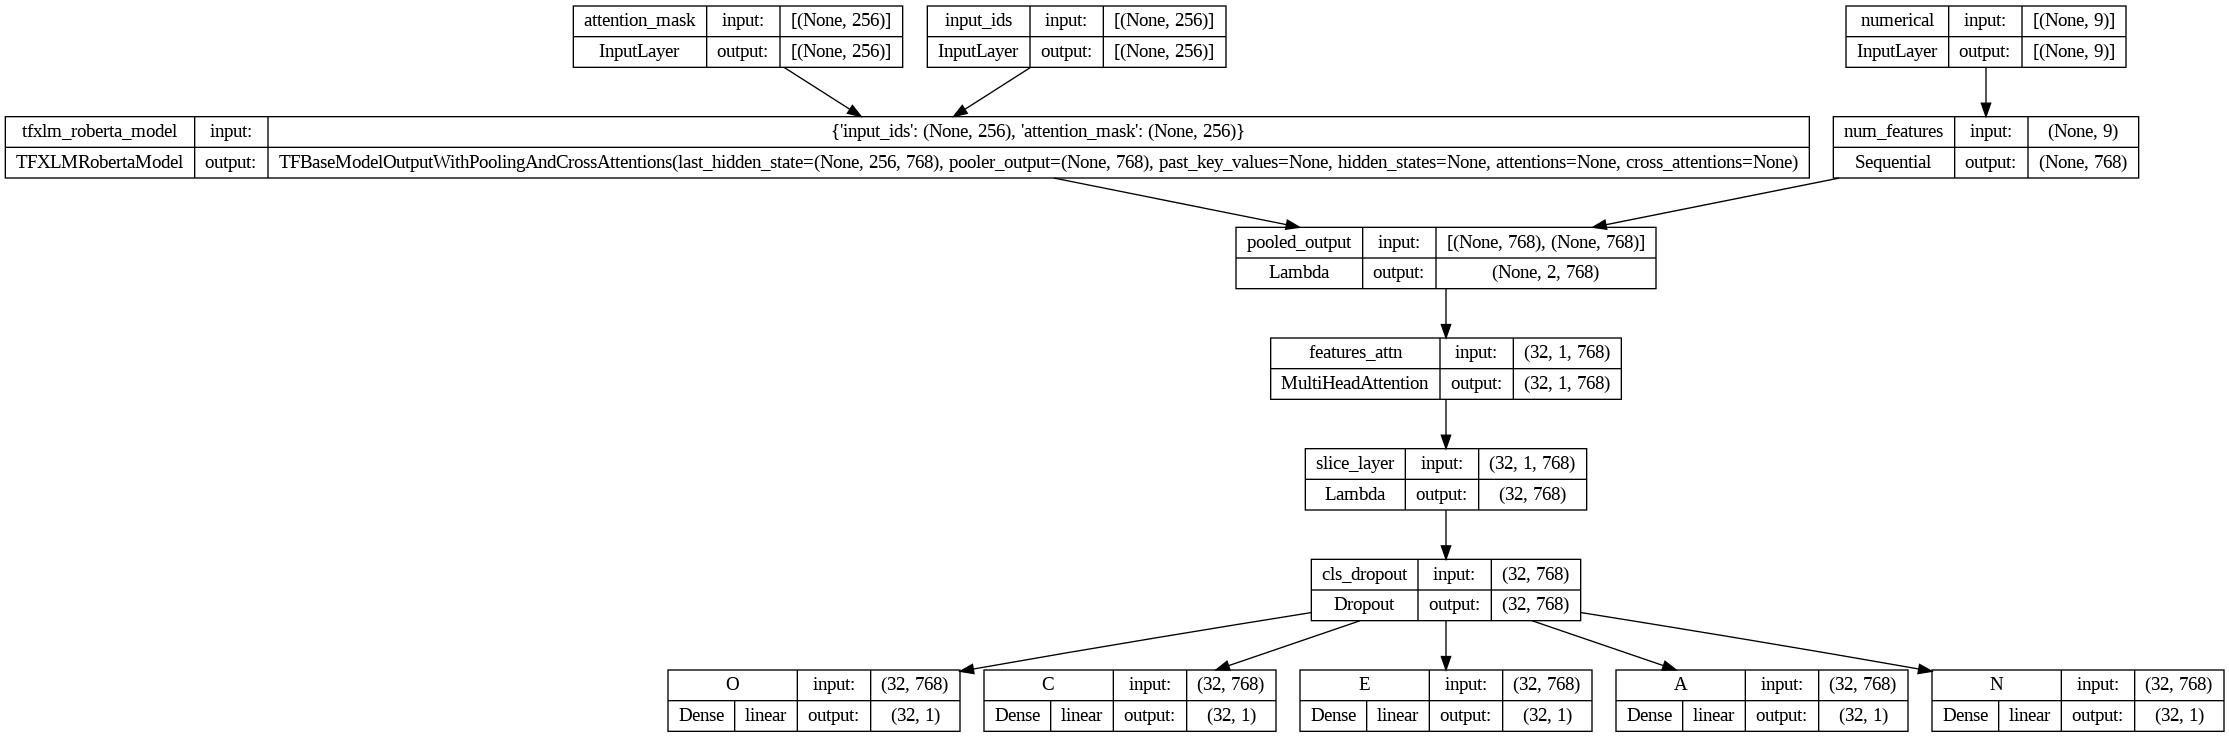

In [ ]:
tf.keras.utils.plot_model(model,show_layer_activations=True,show_shapes=True)